In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

## Reading data

In [9]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj obraz
        img = Image.open(img_path).convert('RGB')
        img_pil = img.copy()
        img_pil.thumbnail(target_size, Image.BICUBIC)

        # Padding
        delta_w = target_size[0] - img_pil.size[0]
        delta_h = target_size[1] - img_pil.size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
        img_padded = ImageOps.expand(img_pil, padding, fill=(0, 0, 0))

        # Konwersja do numpy i normalizacja
        img_array = np.array(img_padded) / 255.0  # Normalizacja [0, 1]

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)

    return np.array(X), np.array(y)

## Building the model

In [10]:
base_model = MobileNet(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Zamroź warstwy

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Wyjście
])


model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

## Getting the training set

In [11]:
X_1, y_1 = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

In [12]:
X_2, y_2 = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

In [13]:
X = np.concatenate([X_1, X_2], axis=0)
y = np.concatenate([y_1, y_2], axis=0)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(32)
history = model.fit(dataset, batch_size=32,
    epochs=20, validation_data=(X_test, y_test)
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 616ms/step - loss: 24806.8965 - mae: 126.2312 - val_loss: 20731.7012 - val_mae: 118.1945
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 556ms/step - loss: 23193.2871 - mae: 119.4658 - val_loss: 14792.2236 - val_mae: 90.7764
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 539ms/step - loss: 14742.8936 - mae: 85.4875 - val_loss: 7119.5195 - val_mae: 68.7774
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 587ms/step - loss: 8921.2949 - mae: 73.7209 - val_loss: 6513.7744 - val_mae: 59.9585
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 592ms/step - loss: 8655.0107 - mae: 69.6362 - val_loss: 6195.7178 - val_mae: 59.6191
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 586ms/step - loss: 8237.7061 - mae: 68.1985 - val_loss: 5973.8647 - val_mae: 58.1395
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 642ms/step - loss: 7899.8364 - mae: 66.8474 - val_loss: 5696.6655 - val_mae: 56.1375
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 621ms/step - loss: 7468.2227 - mae: 64.6851 - val_loss: 5342.

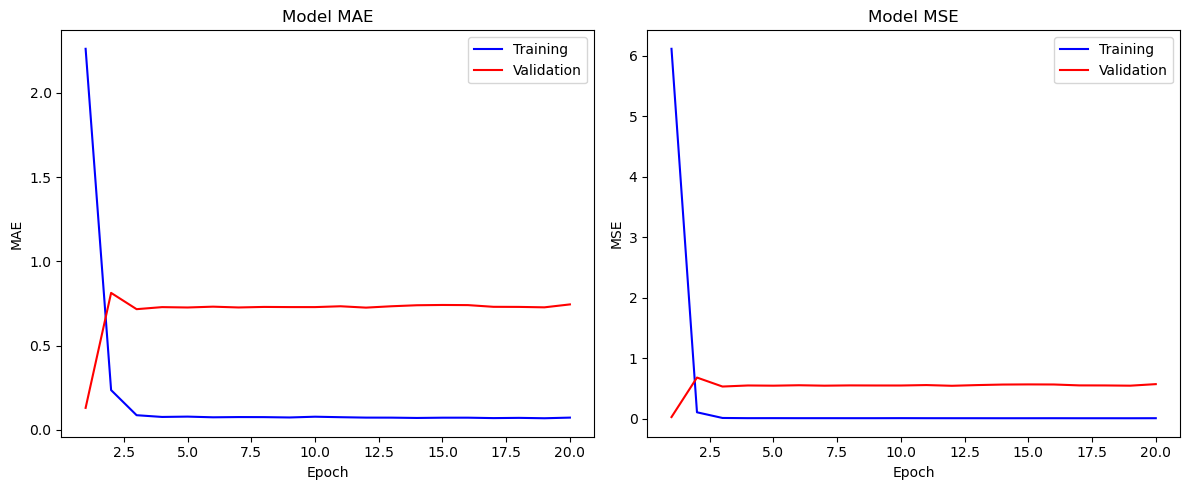

In [153]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [166]:
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 855ms/step


In [167]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[1.07543755 5.05624581]
 [0.96062714 5.59098698]
 [0.92978436 4.46590812]
 [1.04131579 4.9698133 ]
 [1.04501879 4.00733319]
 [0.86264056 3.61091791]
 [0.89311159 3.8918203 ]
 [0.86697841 3.76120012]
 [0.97670925 4.77912349]
 [0.87706524 5.64190707]
 [0.88323253 4.67282883]
 [1.02374649 3.58351894]
 [1.05665326 4.93447393]
 [1.06410873 5.52942909]
 [1.00950456 4.82028157]
 [1.03236711 4.99043259]
 [0.90945584 4.31748811]
 [0.90394419 4.86753445]
 [0.87970066 4.4543473 ]
 [0.96529549 5.17614973]
 [0.93063074 4.17438727]
 [0.90768301 3.36729583]
 [1.00408256 4.89034913]
 [0.96261102 4.54329478]
 [0.90868849 5.70044357]
 [1.08041036 5.38449506]
 [0.99953038 4.12713439]
 [0.94823891 4.71849887]
 [0.88295853 4.47733681]
 [0.97574776 3.98898405]
 [1.16782331 4.30406509]
 [0.94222355 4.55387689]
 [0.95489317 5.58349631]
 [0.95937008 5.11799381]
 [1.10455835 3.36729583]
 [0.95707875 4.2341065 ]
 [1.05265605 5.43807931]
 [0.9033674  5.11198779]
 [0.87938309 3.58351894]
 [0.83453614 4.20469262]


In [168]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

-27.355559285354847